# Tutorial 4: Breast Cancer Analysis with GLAND (UMAP)
This notebook demonstrates the workflow of using embeddings generated by the GLAND model to perform UMAP dimensionality reduction for revealing tissue subgroups.

## Environment Configuration


In [1]:
#First, we import the necessary libraries and configure the computation device. We also set the R_HOME environment variable to ensure mclust (required for clustering) functions correctly within the Python environment.
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
from sklearn.metrics import normalized_mutual_info_score
from GLAND import GLAND
from GLAND.utils import clustering

# Set computation device (GPU is highly recommended for GLAND training)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configure R environment for mclust algorithm
# Path mapped to your conda environment
os.environ['R_HOME'] =r'your R'

Using device: cuda:3


## Data Loading and Preprocessing

In [2]:
#We will use the Human_Breast_Cancer dataset as an example. This step involves loading the Visium data and ensuring the gene names are unique.
# Configuration
dataset = 'Human_Breast_Cancer'
n_clusters = 20  # Number of layers/clusters expected
file_fold = r'/mnt/first19T/liufk/x/'  # Path to your data directory

# Load Visium data
adata = sc.read_visium(os.path.join(file_fold, dataset), load_images=True)
adata.var_names_make_unique()
print(f"Successfully loaded dataset {dataset}")
adata

/mnt/first19T/liufk/anaconda3/envs/GraphST-main/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Successfully loaded dataset Human_Breast_Cancer


/mnt/first19T/liufk/anaconda3/envs/GraphST-main/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## Model Training and Spatial Clustering

Total number of points before filtering: 3798

Filtering using a fixed threshold: 1.8

Total number of points after filtering: 3793
Number of points filtered out: 5


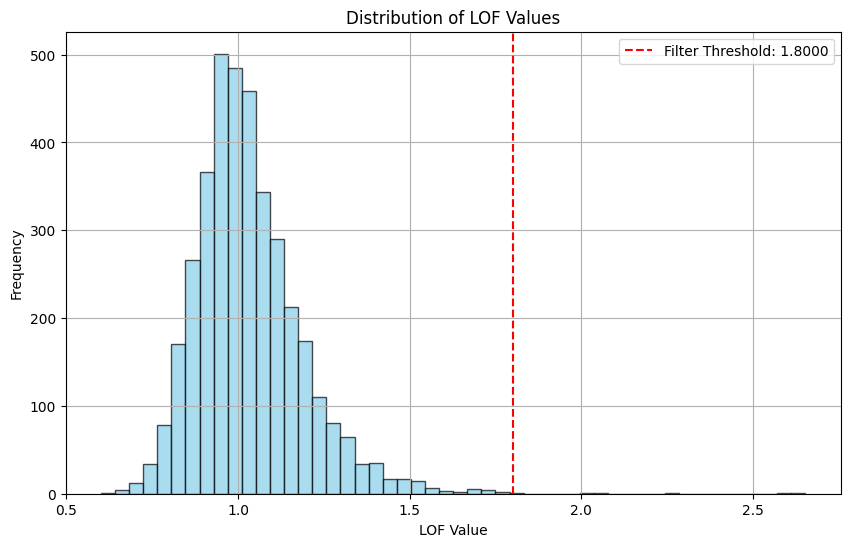

/mnt/first19T/liufk/GLAND/preprocess.py:115: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


Begin to train ST data...


 50%|████████████████████████████████▌                                | 200/400 [00:15<00:15, 12.79it/s]

Updating adjacency matrix at epoch 200...


100%|█████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.53it/s]


Optimization finished for ST data!


by .GlobalEnv when processing object ‘.pbd_env’
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [3]:
# Initialize the GLAND model
model = GLAND.GLAND(
    adata, 
    device=device, 
    epochs=400, 
    dataset=dataset, 
    n_clusters=n_clusters,lofk=5,dim_output=64
)
# Train the model
adata = model.train()
# Clustering settings
radius = 20     # Radius for spatial refinement
# Refinement is recommended for the DLPFC dataset to reduce noise
clustering(adata, n_clusters, radius=radius, method='mclust', refinement=True) 

## Evaluation and Visualization

/tmp/ipykernel_2732930/394640301.py:13: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ARI'] = ARI


[<Axes: title={'center': 'GLAND  ARI=0.624'}, xlabel='spatial1', ylabel='spatial2'>]

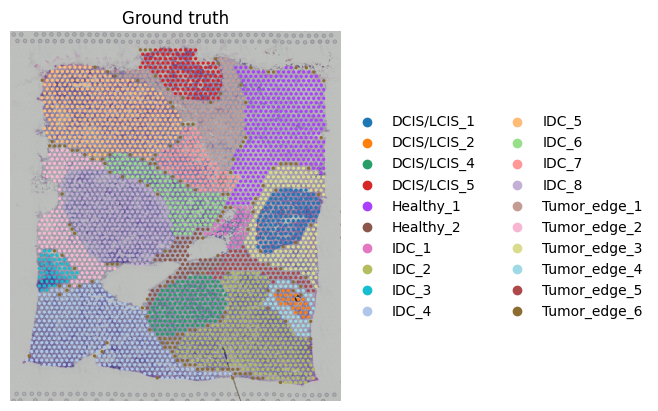

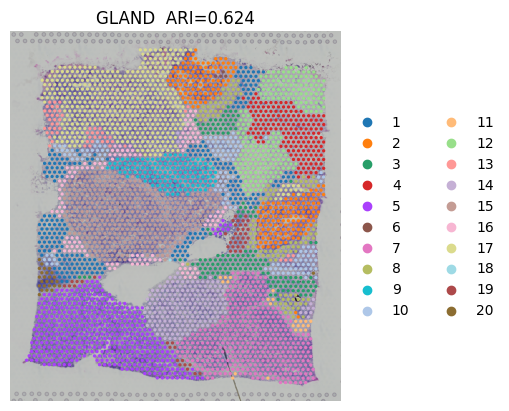

In [4]:
# Load ground truth metadata
df_meta = pd.read_csv(os.path.join(file_fold, dataset, 'metadata.tsv'), sep='\t')
adata.obs['ground_truth'] = df_meta['ground_truth'].values
# Filter out spots missing ground truth or domain labels
adata = adata[~pd.isnull(adata.obs['ground_truth'])]
adata = adata[~pd.isnull(adata.obs['domain'])]

# Calculate Metrics
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
NMI = normalized_mutual_info_score(adata.obs['domain'], adata.obs['ground_truth'])

# Store metrics in AnnData
adata.uns['ARI'] = ARI
adata.uns['NMI'] = NMI

sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth"],
              title=["Ground truth"],
              show=False,frameon=False)

# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["domain"],
              title="GLAND" + "  ARI=" + "{:.3f}".format(adata.uns["ARI"]),
              show=False,frameon=False)


## UMAP

/mnt/first19T/liufk/anaconda3/envs/GraphST-main/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'UMAP'}, xlabel='UMAP1', ylabel='UMAP2'>

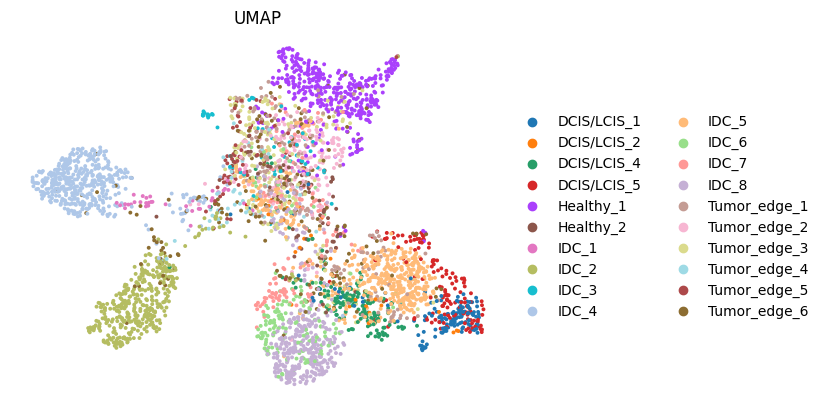

In [6]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["ground_truth"], title=["UMAP"], show=False,frameon=False)